# Regions investigation and workspace
This notebook allows to both:
- investigate the existing regioner on the given dataste
- develop new regioner and see the results live


In [1]:
import importlib
from functools import partial
from utils import *

root_dir = add_root_to_path(3)

import skimage.morphology
import sep.inspect.regions as regions_inspect
import sep.assessors.regions as regions
import sep._commons.visuals as visuals

## Prepare dataset

In [2]:
import sep.loaders.images
data_root = pick_path([root_dir / "tests" / "input" / "basics"])
dataset = data_root / "humans"
data_loader = sep.loaders.images.ImagesLoader.from_tree(str(dataset))

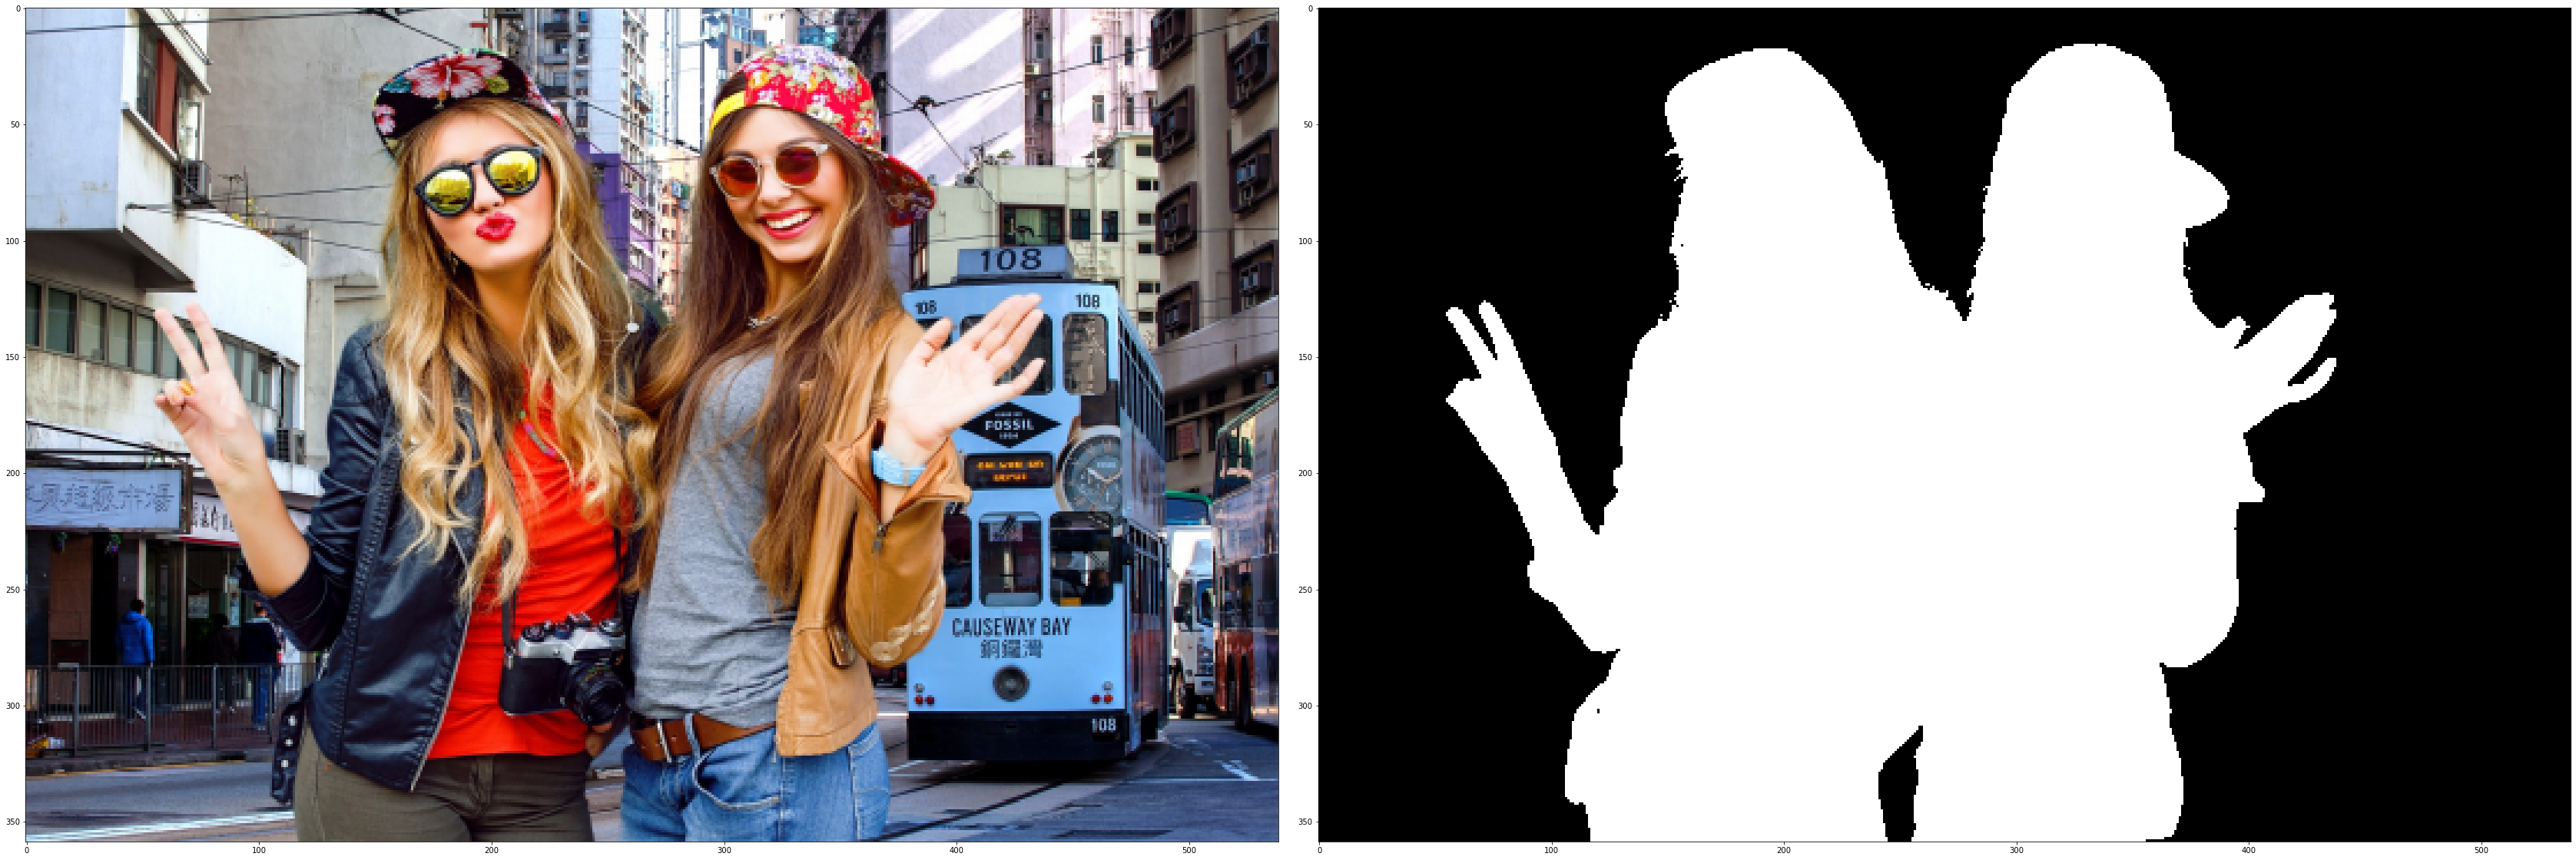

In [3]:
image = data_loader[0]['image']
annotation = data_loader[0]['annotation']
show_all(1, 2, image, annotation);

## Develop new regioner
In this section you can develop a new regionizer which you can later move to the actual Regioner class.

In [4]:
image_num = 0
image = data_loader[image_num]['image']
annotation = data_loader[image_num]['annotation']

In [5]:
def new_extract_region1(ground_truth, size) -> np.ndarray:
    selem = skimage.morphology.disk(size)
    opened = skimage.morphology.binary_opening(ground_truth, selem)
    return (ground_truth>0) > opened

def new_extract_region2(ground_truth) -> np.ndarray:
    selem = skimage.morphology.disk(31)
    dilated = skimage.morphology.binary_dilation(ground_truth, selem)
    eroded =  skimage.morphology.binary_erosion(ground_truth, selem)
    return ground_truth == (dilated > eroded)

 <class 'imageio.core.util.Array'>
Shape: (359, 539), Type: bool, Min-max: (False, True), Mean: 0.026098056340794103


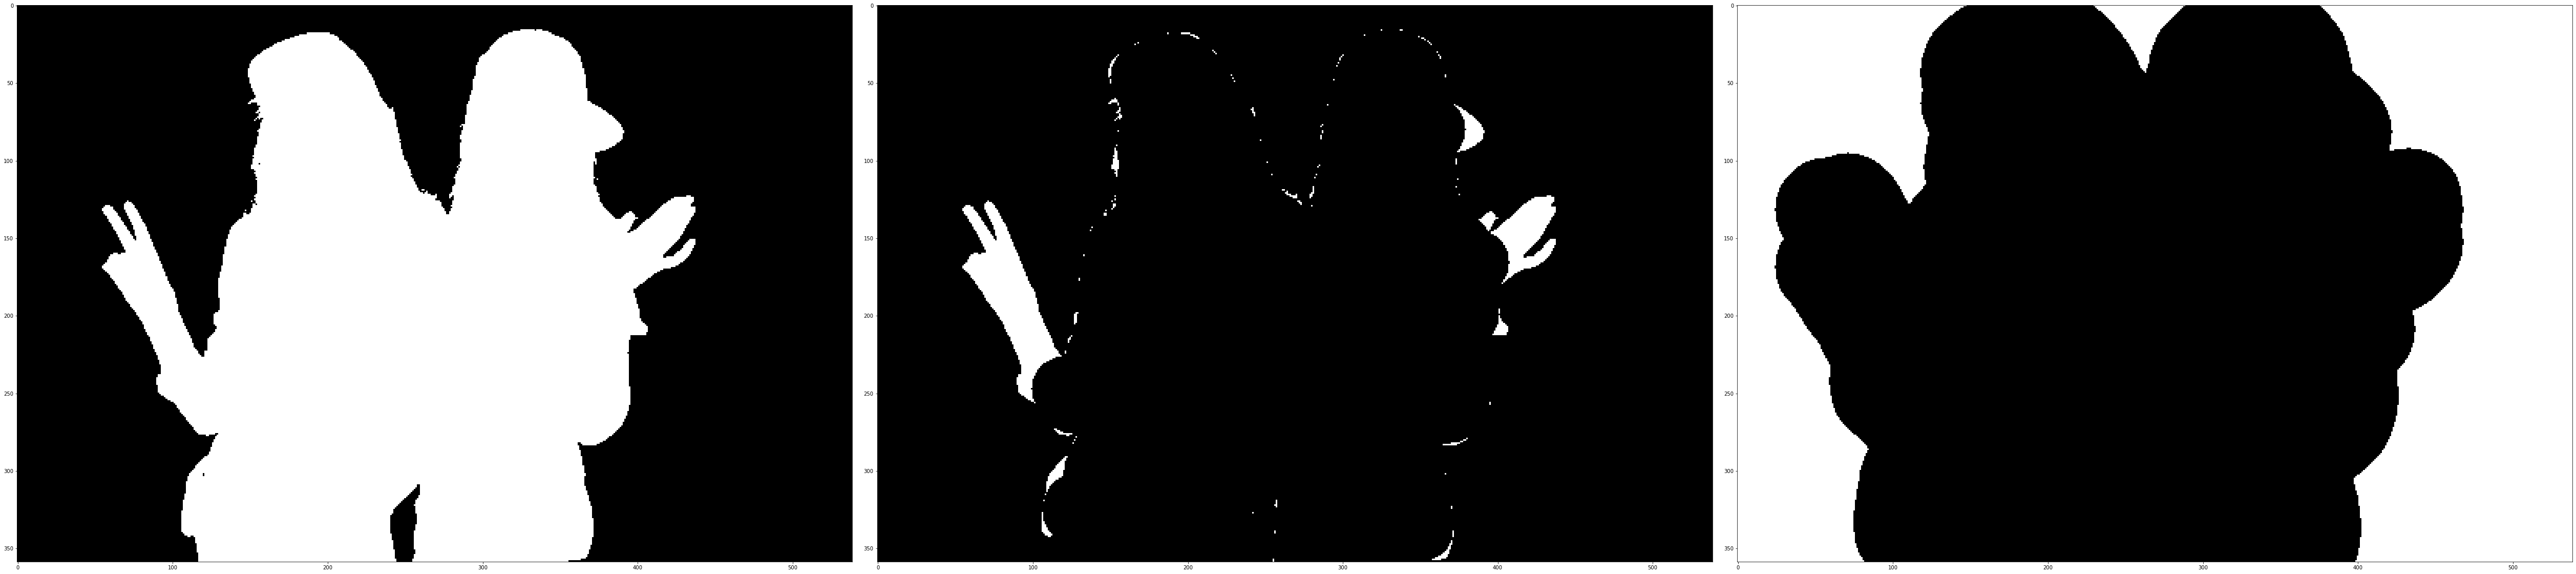

In [6]:
region1 = new_extract_region1(annotation, 20)
region2 = new_extract_region2(annotation)

info(region1)
show_all(1, 3, annotation, region1, region2);

## Investigate the chosen regioner
In this section you can see the regions created by the chosen regionizer on the entire dataset. This allows to visually assess the sensibility of using that regioner.

In [7]:
importlib.reload(regions)
from collections import OrderedDict
regioners = [#regions.EntireRegion(), 
             regions.EdgesRegion(0.02, "2% pixel edge"), #, regions.EdgesRegion(5, "5 pixel edge"), 
             regions.DetailsRegion(0.06, "6% details"), regions.DetailsRegion(0.04, "4% details"), regions.DetailsRegion(0.02, "2% details")]
regioners_dict = OrderedDict([(str(regioner), regioner.extract_region) for regioner in regioners])
#regioners_dict = {"Region A": partial(new_extract_region1, size=15)} #, "Region B": new_extract_region2}

In [8]:
def present_regions(image_num, regioners_dict):
    image = data_loader[image_num]['image']
    annotation = data_loader[image_num]['annotation']
    tag = data_loader[image_num]['tag']
    
    assert image is not None
    assert annotation is not None
    assert tag is not None
    
    regions = []
    regions_names = []
    for region_name, region_fun in regioners_dict.items():
        regions.append(region_fun(annotation))
        regions_names.append(region_name)

    print(tag)
    print(image.shape)
    overlay, legend = regions_inspect.overlay_regions(image=image, regions=regions, regions_names=regions_names)
    display(visuals.show_with_legend(overlay, legend, titles=""))

In [9]:
import random
dataset_len = len(data_loader)
print(f"Dataset consists of {dataset_len} images.")
random_order = list(range(dataset_len))
random.shuffle(random_order)
current = 0
print(random_order)

Dataset consists of 3 images.
[2, 1, 0]


### Run investigation loop

Presenting 2:
{'id': 'human_3', 'source': 'shm_paper', 'type': 'girls'}
(358, 646, 3)


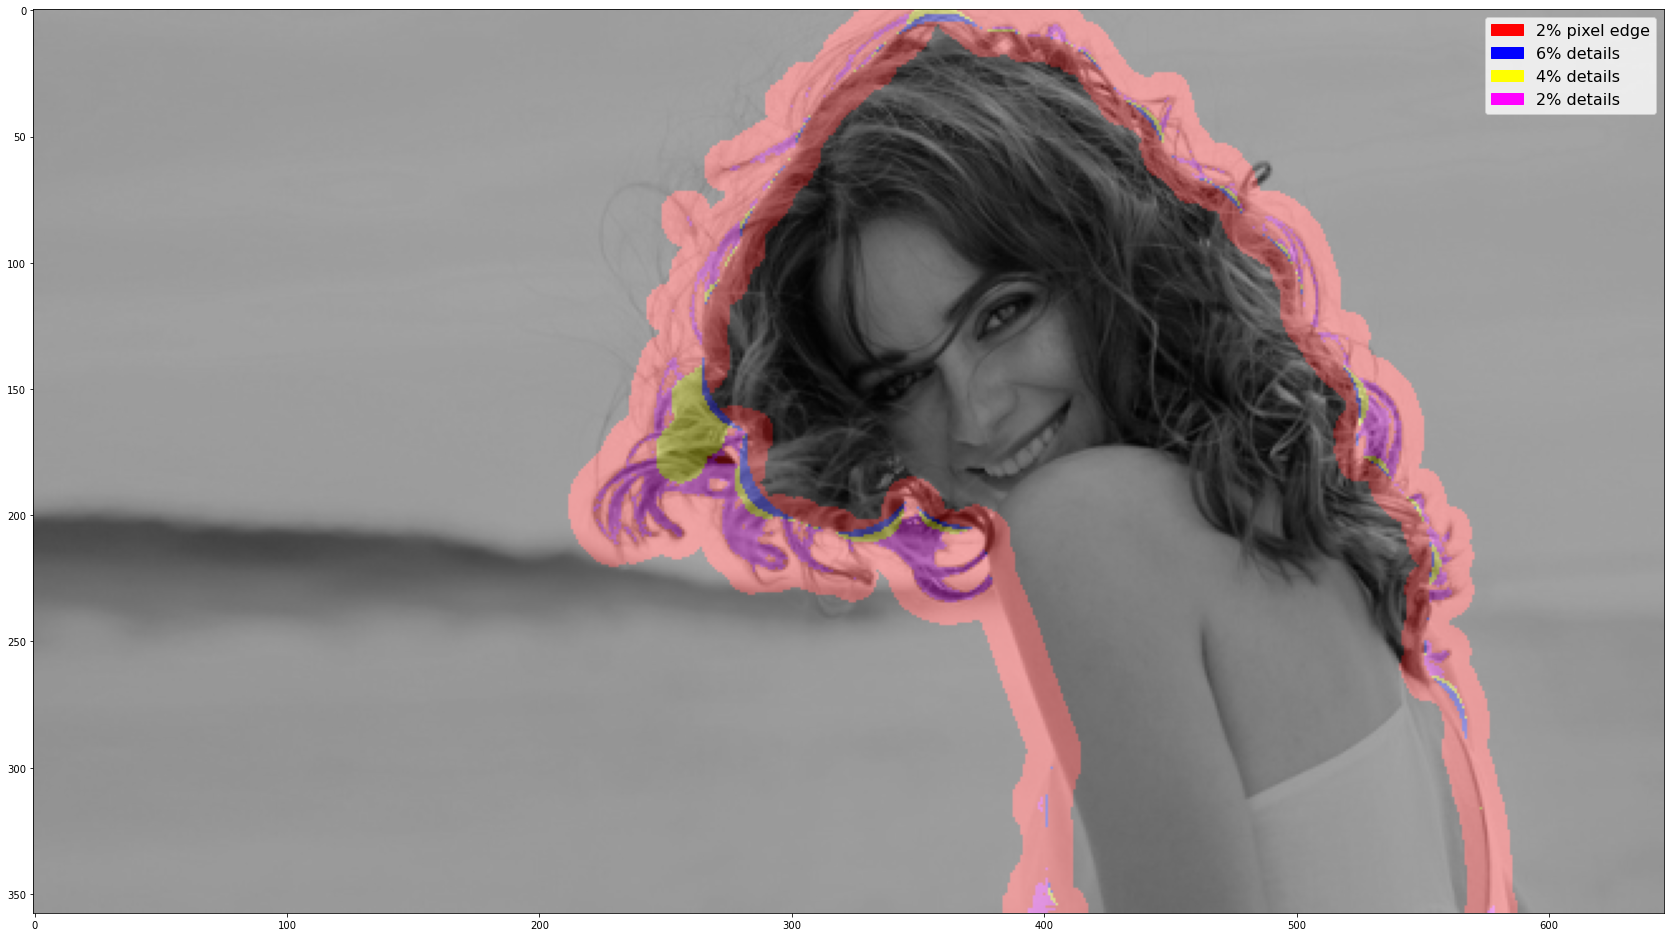

In [10]:
print(f"Presenting {random_order[current]}:")
present_regions(random_order[current], regioners_dict)

current += 1
if current == dataset_len:
    print("Checked all images in the dataset, rewinding to first one.")
    current = 0

## Show standard set of regions

### Entire vs on edges pixels

{'id': 'human_1', 'source': 'shm_paper', 'type': 'girls'}
(359, 539, 3)


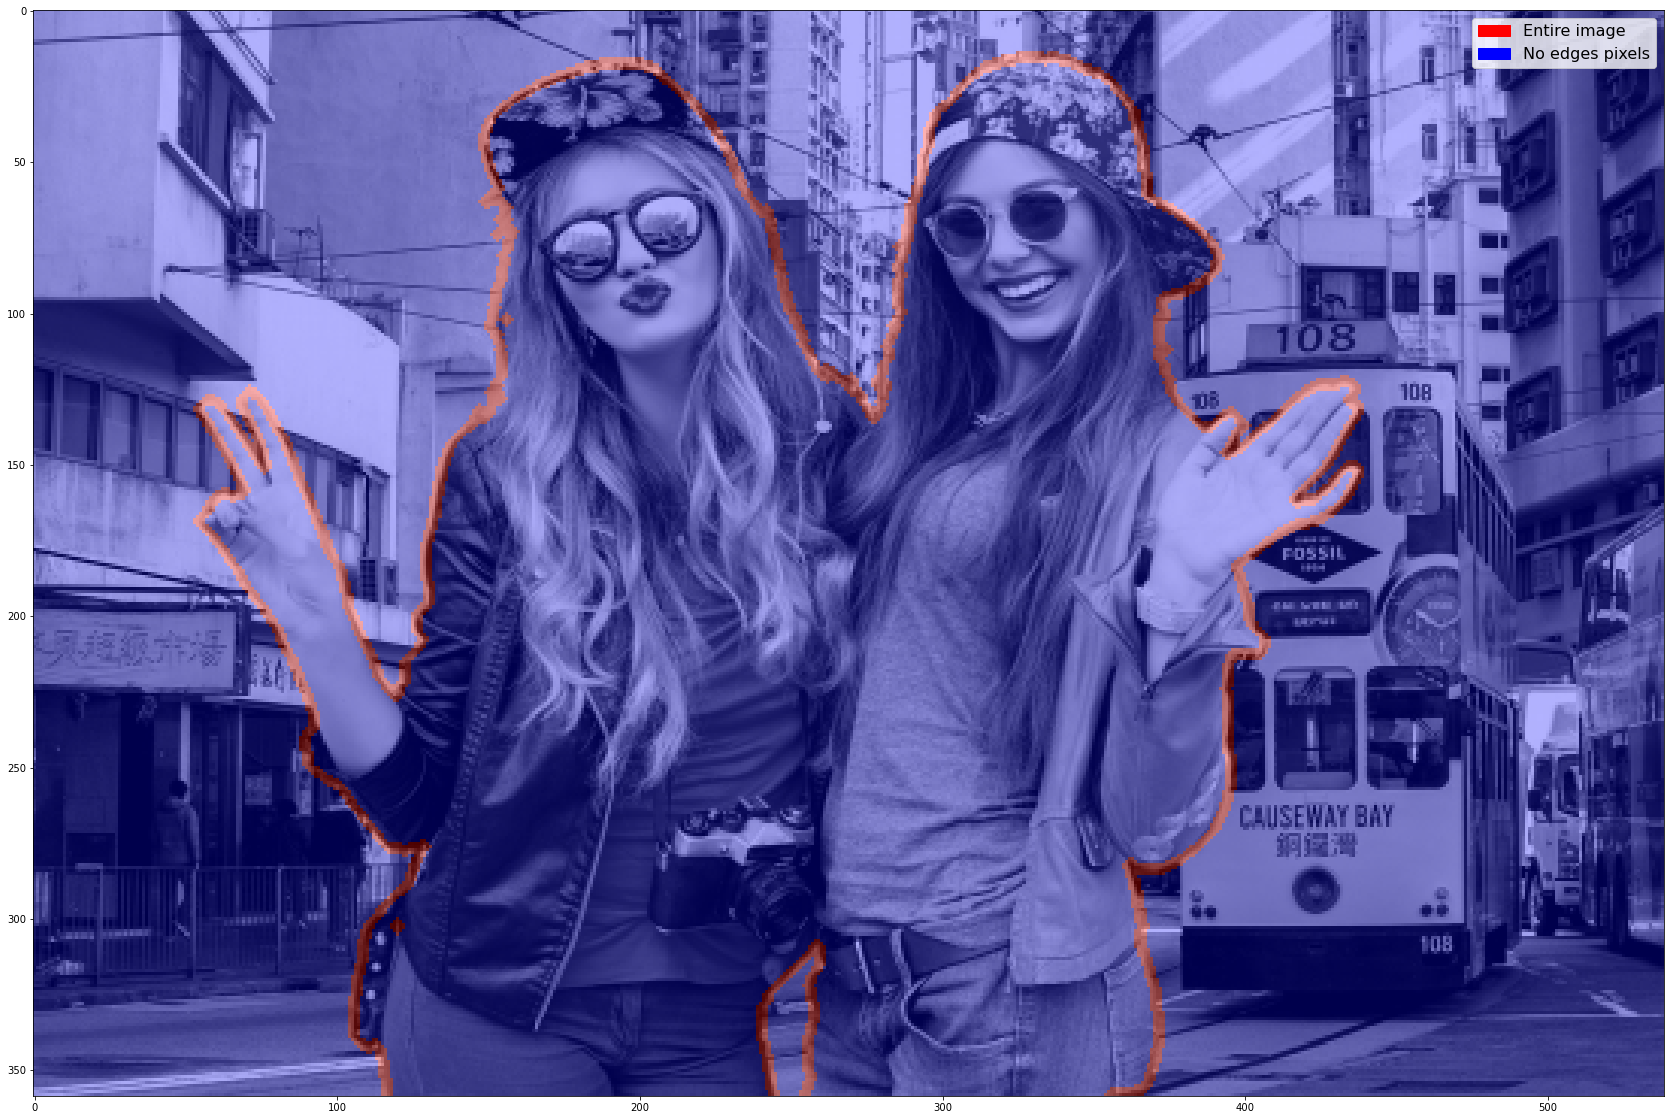

### Precise vs robust

{'id': 'human_1', 'source': 'shm_paper', 'type': 'girls'}
(359, 539, 3)


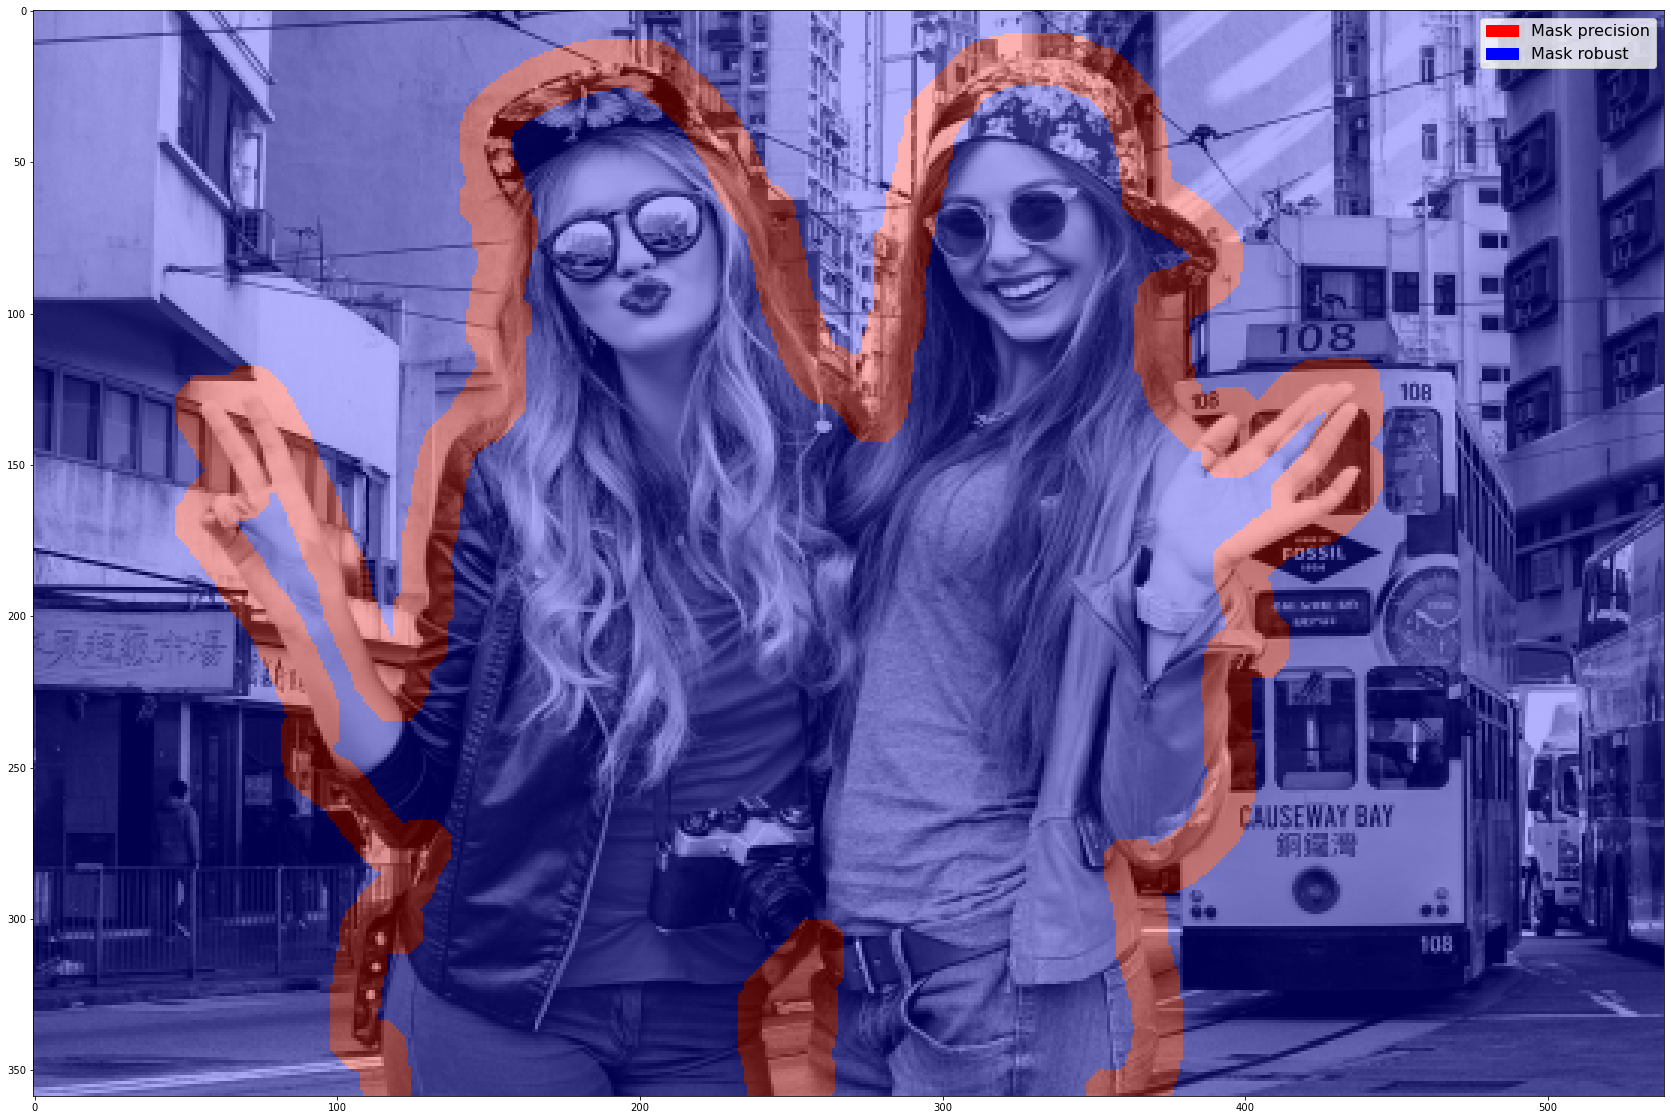

### No Edges Details

{'id': 'human_1', 'source': 'shm_paper', 'type': 'girls'}
(359, 539, 3)


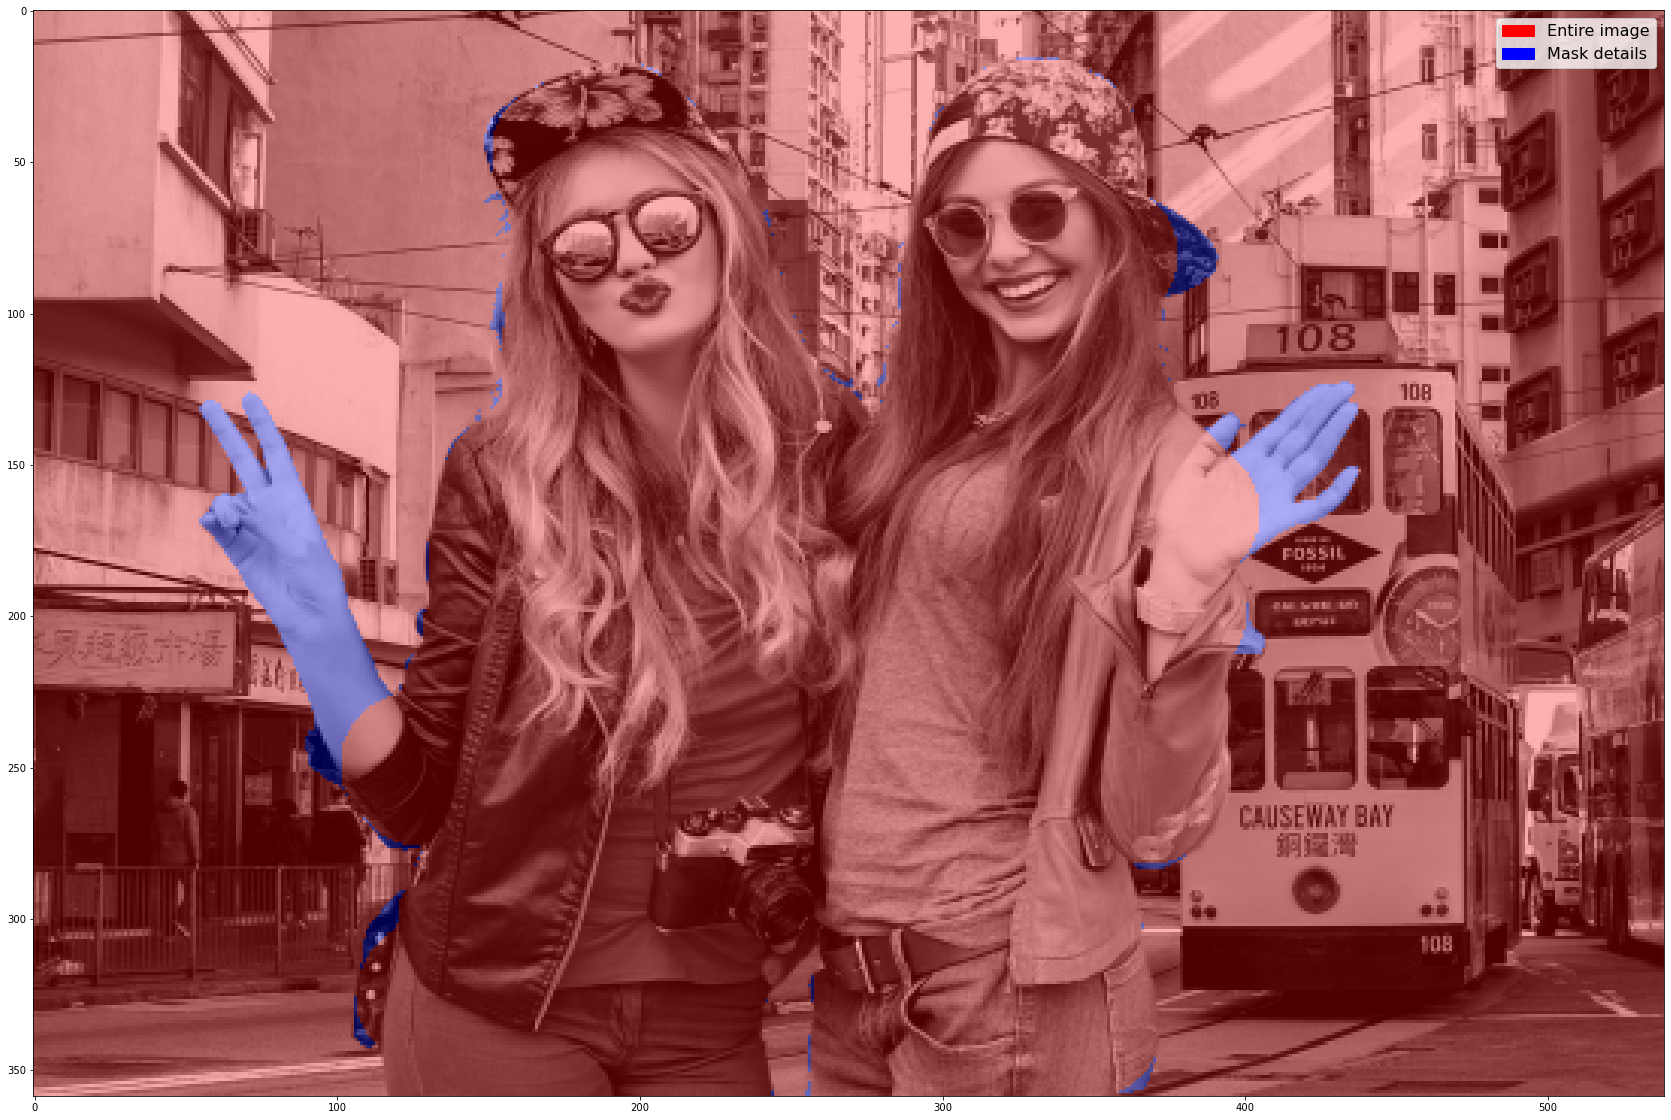

In [11]:
importlib.reload(regions)
from collections import OrderedDict
regioners_standard = regions.set_standard
regioners_standard_dict = OrderedDict([(str(regioner), regioner.extract_region) for regioner in regioners_standard])

image_num = random_order[2]
printmd("### Entire vs on edges pixels")
present_regions(image_num, {k: v for k,v in regioners_standard_dict.items() if k in ['Entire image', 'No edges pixels']})

printmd("### Precise vs robust")
present_regions(image_num, {k: v for k,v in regioners_standard_dict.items() if k in ['Mask precision', 'Mask robust']})

printmd("### No Edges Details")
present_regions(image_num, {k: v for k,v in regioners_standard_dict.items() if k in ['Entire image', 'Mask details']})